In [1]:
import numpy as np
import tensorflow as tf
import matplotlib.pyplot as plt
import time
from matplotlib.patches import Rectangle
from matplotlib import cm
from scipy.stats import qmc
import math

2024-04-07 17:05:14.251146: I tensorflow/core/util/port.cc:110] oneDNN custom operations are on. You may see slightly different numerical results due to floating-point round-off errors from different computation orders. To turn them off, set the environment variable `TF_ENABLE_ONEDNN_OPTS=0`.
2024-04-07 17:05:14.363781: I tensorflow/core/platform/cpu_feature_guard.cc:182] This TensorFlow binary is optimized to use available CPU instructions in performance-critical operations.
To enable the following instructions: AVX2 AVX_VNNI FMA, in other operations, rebuild TensorFlow with the appropriate compiler flags.
2024-04-07 17:05:15.163199: W tensorflow/compiler/tf2tensorrt/utils/py_utils.cc:38] TF-TRT Warning: Could not find TensorRT


In [2]:
if tf.config.list_physical_devices('GPU'):
    print("GPU is available")
else:
    print("GPU is not available")

GPU is available


2024-04-07 17:05:17.245416: I tensorflow/compiler/xla/stream_executor/cuda/cuda_gpu_executor.cc:982] could not open file to read NUMA node: /sys/bus/pci/devices/0000:01:00.0/numa_node
Your kernel may have been built without NUMA support.
2024-04-07 17:05:17.360521: I tensorflow/compiler/xla/stream_executor/cuda/cuda_gpu_executor.cc:982] could not open file to read NUMA node: /sys/bus/pci/devices/0000:01:00.0/numa_node
Your kernel may have been built without NUMA support.
2024-04-07 17:05:17.360592: I tensorflow/compiler/xla/stream_executor/cuda/cuda_gpu_executor.cc:982] could not open file to read NUMA node: /sys/bus/pci/devices/0000:01:00.0/numa_node
Your kernel may have been built without NUMA support.


In [3]:
#torch.manual_seed(42)
#np.random.seed(42)

In [4]:
tf.keras.backend.set_floatx("float64")

In [5]:
class Puasson2DPINN():
    def __init__(self, input_shape=1, out_shape=1, layers=[10, 10, 10], activation='tanh', optimizer=tf.keras.optimizers.Adam(learning_rate=1e-04)):
        super(Puasson2DPINN, self).__init__()
        self.optimizer = optimizer
        self.model = self.build(input_shape, out_shape, layers, activation)

    def build(self, input_shape, output_shape, layers, activation):
        input_layer = tf.keras.layers.Input(shape=(input_shape,))
        kernel_initializer = tf.keras.initializers.GlorotNormal(seed=177013)

        hidden = [tf.keras.layers.Dense(layers[0], activation=activation)(input_layer)]
        for i in range(1, len(layers)):
            new_layer = tf.keras.layers.Dense(
                    layers[i],
                    activation=activation,
                    activity_regularizer=None
                )(hidden[-1])
            hidden.append(new_layer)

        output_layer = tf.keras.layers.Dense(output_shape, activation=None)(hidden[-1])

        name = f"DNN-{len(layers)}"
        model = tf.keras.Model(input_layer, output_layer, name=name)
        model.summary()
    
        return model


    def forward(self, x1_x2):
        x1_x2 = tf.convert_to_tensor(x1_x2, dtype=tf.float64)
        
        with tf.GradientTape(persistent=True) as tape2:
            tape2.watch(x1_x2)
            with tf.GradientTape() as tape:
                tape.watch(x1_x2)
                u = self.model(x1_x2)
            grads = tape.gradient(u, x1_x2)
            u_x1, u_x2 = grads[:, 0], grads[:, 1]
        grads2 = tape2.gradient(u_x1, x1_x2)
        u_x1_x1 = grads2[:, 0]

        grads3 = tape2.gradient(u_x2, x1_x2)
        u_x2_x2 = grads3[:, 1]

        del tape2

        return u, u_x1, u_x2, u_x1_x1, u_x2_x2

    @tf.function
    def dirichlet_condition(self, x1_bc, x2_bc, u_bc):
        x_t = tf.concat([x1_bc, x2_bc], axis=1)
        u = self.model(x_t)
        return tf.reduce_mean(tf.square(u - u_bc))

    @tf.function
    def neuman_condition(self, x1_bc_neuman, x2_bc_neuman):
        x1_left = x1_bc_neuman[:len(x2_bc_neuman)//2]
        x2_left = x2_bc_neuman[:len(x2_bc_neuman)//2]
        x1_right = x1_bc_neuman[len(x2_bc_neuman)//2:]
        x2_right = x2_bc_neuman[len(x2_bc_neuman)//2:]
        x1_x2_left = tf.concat([x1_left, x2_left], axis=1)
        x1_x2_right = tf.concat([x1_right, x2_right], axis=1)

        u_left = self.model(x1_x2_left)
        u_x1_left = tf.gradients(u_left, x1_left)[0]
        u_right = self.model(x1_x2_right)
        u_x1_right = tf.gradients(u_right, x1_right)[0]

        return tf.reduce_mean(tf.square(-u_x1_left - alpha * u_left)) + tf.reduce_mean(tf.square(u_x1_right))

    @tf.function
    def loss_fn(self, x1_in, x2_in, x1_bc, x2_bc, u_bc, x1_bc_neuman, x2_bc_neuman):
        x_t = tf.concat([x1_in, x2_in], axis=1)
        u0 = self.model(x_t)
        u_x = tf.gradients(u0, x1_in)[0]
        u_y = tf.gradients(u0, x2_in)[0]
        u_xx = tf.gradients(u_x, x1_in)[0]
        u_yy = tf.gradients(u_y, x2_in)[0]
        puasson_eq = u_xx + u_yy #self.f(x1_x2_train)
        bc_dirichlet = self.dirichlet_condition(x1_bc, x2_bc, u_bc)
        bc_neuman = self.neuman_condition(x1_bc_neuman, x2_bc_neuman)

        return tf.reduce_mean(tf.square(puasson_eq)) + 100 * (bc_dirichlet + bc_neuman)
    
    def train(self, loss_threshold, x1_in, x2_in, x1_bc, x2_bc, u_bc, x1_bc_neuman, x2_bc_neuman):
        loss_array = []
        start_time = time.time()

        loss = tf.constant(float('inf'))
        epoch = 0
        try:
            while loss.numpy() > loss_threshold:
                with tf.GradientTape() as tape:
                    loss = self.loss_fn(x1_in, x2_in, x1_bc, x2_bc, u_bc, x1_bc_neuman, x2_bc_neuman)
                grads = tape.gradient(loss, self.model.trainable_variables)
                self.optimizer.apply_gradients(zip(grads, self.model.trainable_variables))

                loss_array.append(loss)
                if epoch % 100 == 0:
                    print(f'Epoch {epoch}, Loss: {loss.numpy()}')
                epoch += 1
        except KeyboardInterrupt:
            print("Training stopped manually")

        print("Training took %s seconds" % (time.time() - start_time))
        print(f"Last epoch: {epoch}, loss: {loss.numpy()}")

        plt.plot(loss_array)
        plt.xlabel('Epoch')
        plt.ylabel('Loss')
        plt.grid()
        plt.title('Mean loss')
        plt.savefig("2d_poisson_robin_equation_training.png")
        plt.show(block=False)

    def f(self, x1_x2):
        x1 = np.array([x[0] for x in x1_x2])
        x2 = np.array([x[1] for x in x1_x2])
        return -np.pi * np.sin(np.pi * x1) * np.sin(np.pi * x2)

2024-04-07 17:05:17.447816: I tensorflow/compiler/xla/stream_executor/cuda/cuda_gpu_executor.cc:982] could not open file to read NUMA node: /sys/bus/pci/devices/0000:01:00.0/numa_node
Your kernel may have been built without NUMA support.
2024-04-07 17:05:17.447934: I tensorflow/compiler/xla/stream_executor/cuda/cuda_gpu_executor.cc:982] could not open file to read NUMA node: /sys/bus/pci/devices/0000:01:00.0/numa_node
Your kernel may have been built without NUMA support.
2024-04-07 17:05:17.447962: I tensorflow/compiler/xla/stream_executor/cuda/cuda_gpu_executor.cc:982] could not open file to read NUMA node: /sys/bus/pci/devices/0000:01:00.0/numa_node
Your kernel may have been built without NUMA support.
2024-04-07 17:05:17.767933: I tensorflow/compiler/xla/stream_executor/cuda/cuda_gpu_executor.cc:982] could not open file to read NUMA node: /sys/bus/pci/devices/0000:01:00.0/numa_node
Your kernel may have been built without NUMA support.
2024-04-07 17:05:17.768120: I tensorflow/compile

In [6]:
N_of_train_points_2D = 141
N_of_test_points_2D = 1000
L_x1 = 0.0
R_x1 = 1.0
L_x2 = 0.0
R_x2 = 1.0
alpha = 1
Dirichlet_up_2D = 1.0
Dirichlet_down_2D = 0.0
loss_threshold_2D = 1e-3
Layers_2D = [20, 20, 20, 20, 20, 20, 20, 20, 20]
Learning_rate_2D = 5e-4
Optimizer_2D = tf.keras.optimizers.Adam(learning_rate=Learning_rate_2D)


model_2D = Puasson2DPINN(2, 1, Layers_2D, 'tanh', Optimizer_2D)
# tf.keras.utils.plot_model(model_2D.model, to_file='model_plot.png', show_shapes=True, 
#                           show_layer_names=True, show_dtype=True, 
#                           show_layer_activations=True)

Model: "DNN-9"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_1 (InputLayer)        [(None, 2)]               0         
                                                                 
 dense (Dense)               (None, 20)                60        
                                                                 
 dense_1 (Dense)             (None, 20)                420       
                                                                 
 dense_2 (Dense)             (None, 20)                420       
                                                                 
 dense_3 (Dense)             (None, 20)                420       
                                                                 
 dense_4 (Dense)             (None, 20)                420       
                                                                 
 dense_5 (Dense)             (None, 20)                420   

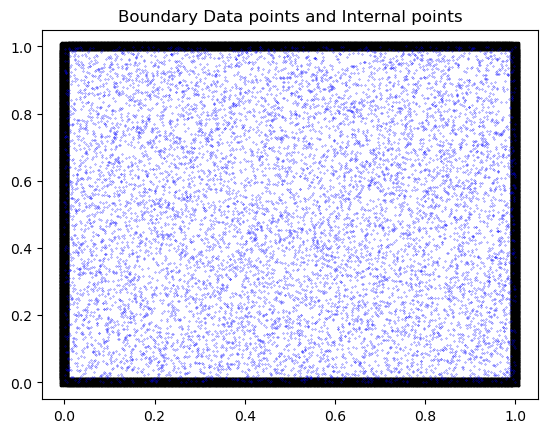

In [7]:
# Data generation
n_bc = 4
n_bc_dirichlet = 2
n_bc_neuman = 2
n_data_per_bc = 1000
Nc = 10000

engine = qmc.LatinHypercube(d=1)
data_dirichlet = np.zeros([2, n_data_per_bc, 3])
data_neuman = np.zeros([2, n_data_per_bc, 3])

for i, j in zip(range(n_bc_dirichlet), [L_x2, R_x2]):
    points = L_x1 + engine.random(n=n_data_per_bc)[:, 0] * (R_x1 - L_x1)
    data_dirichlet[i, :, 0] = points
    data_dirichlet[i, :, 1] = j

for i, j in zip(range(n_bc_neuman), [L_x1, R_x1]):
    points = L_x2 + engine.random(n=n_data_per_bc)[:, 0] * (R_x2 - L_x2)
    data_neuman[i, :, 0] = j
    data_neuman[i, :, 1] = points

# BC Values
data_dirichlet[0, :, 2] = 1.0
data_dirichlet[1, :, 2] = 0.0

data_dirichlet = data_dirichlet.reshape(n_data_per_bc * n_bc_dirichlet, 3)
data_neuman = data_neuman.reshape(n_data_per_bc * n_bc_neuman, 3)

x1_bc, x2_bc, u_bc = map(lambda x: np.expand_dims(x, axis=1), 
                    [data_dirichlet[:, 0], data_dirichlet[:, 1], data_dirichlet[:, 2]])

x1_bc_neuman, x2_bc_neuman = map(lambda x: np.expand_dims(x, axis=1), 
                    [data_neuman[:, 0], data_neuman[:, 1]])

engine = qmc.LatinHypercube(d=2)
colloc = engine.random(n=Nc)
colloc = np.column_stack((L_x1 + colloc[:,0] * (R_x1 - L_x1), L_x2 + colloc[:,1] * (R_x2 - L_x2)))

x1_in, x2_in = map(lambda x: np.expand_dims(x, axis=1), 
               [colloc[:, 0], colloc[:, 1]])

plt.title("Boundary Data points and Internal points")
plt.scatter(data_dirichlet[:, 0], data_dirichlet[:, 1], marker="x", c="k", label="BDP")
plt.scatter(data_neuman[:, 0], data_neuman[:, 1], marker="x", c="k", label="BDP")
plt.scatter(colloc[:, 0], colloc[:, 1], s=.2, marker=".", c="b", label="CP")
plt.show()

x1_in, x2_in, x1_bc, x2_bc, u_bc, x1_bc_neuman, x2_bc_neuman = map(
    lambda x: tf.convert_to_tensor(x,dtype=tf.float64),
    [x1_in, x2_in, x1_bc, x2_bc, u_bc, x1_bc_neuman, x2_bc_neuman]
)

2024-04-07 17:05:19.574461: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'gradients/StatefulPartitionedCall_grad/StatefulPartitionedCall_21' with dtype int32
	 [[{{node gradients/StatefulPartitionedCall_grad/StatefulPartitionedCall_21}}]]
2024-04-07 17:05:19.965492: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'gradients/StatefulPartitionedCall_1_grad/StatefulPartitionedCall_1_2' with dtype int32 and shape [2]
	 [[{{node gradients/StatefulPartitionedCall_1_grad/StatefulPartitionedCall_1_2}}]]
2024-04-07 17:05:19.965617: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start a

Epoch 0, Loss: 45.938791317565446
Epoch 100, Loss: 1.242474436207957
Epoch 200, Loss: 0.8035690729330676
Epoch 300, Loss: 0.672243446177009
Epoch 400, Loss: 0.6110421572338423
Epoch 500, Loss: 0.5284703022988019
Epoch 600, Loss: 0.4626806952929533
Epoch 700, Loss: 0.8721026011703876
Epoch 800, Loss: 0.31485863621202437
Epoch 900, Loss: 0.2758124546673774
Epoch 1000, Loss: 0.1996281007658283
Epoch 1100, Loss: 0.1927647535569162
Epoch 1200, Loss: 0.13730319416294792
Epoch 1300, Loss: 0.2705728797185493
Epoch 1400, Loss: 0.10208579495388143
Epoch 1500, Loss: 0.08757300172966834
Epoch 1600, Loss: 0.10048270931634462
Epoch 1700, Loss: 0.06725162005959073
Epoch 1800, Loss: 0.058635192800101876
Epoch 1900, Loss: 0.05192788925200546
Epoch 2000, Loss: 0.04868296940136913
Epoch 2100, Loss: 0.045101105480430316
Epoch 2200, Loss: 0.042463017066460856
Epoch 2300, Loss: 0.040390200254089945
Epoch 2400, Loss: 0.041979614026731345
Epoch 2500, Loss: 0.037739798018561144
Epoch 2600, Loss: 0.036370075266

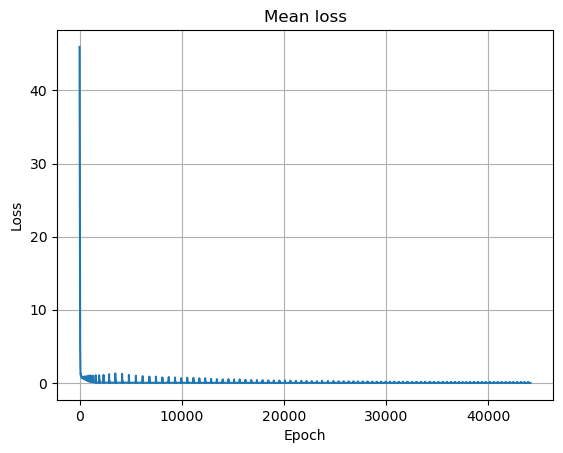

In [8]:
model_2D.train(loss_threshold_2D, x1_in, x2_in, x1_bc, x2_bc, u_bc, x1_bc_neuman, x2_bc_neuman)

In [9]:
def save_and_load_model_2D(model, layers, fileName):
    # Save weights to file
    model.save_weights(f'{fileName}.h5')

    # Instantiate a new model with the same layers and wave speed
    new_model = Puasson2DPINN(layers)

    # Create some dummy input
    dummy_x = np.linspace(0, 1, 10)
    dummy_t = np.linspace(0, 1, 10)
    dummy_xt = np.array([[x1, x2] for x1 in dummy_x for x2 in dummy_t], dtype=np.float64)

    # Call the model on the dummy input to create variables
    _ = new_model(dummy_xt)

    # Load the weights from the saved file
    loaded_model = new_model.load_weights(f'{fileName}.h5')
    return loaded_model
#save_and_load_model_2D(model, layers)

In [10]:
def calculate_max_relative_error(u_pred, u_exact):
    return 100 * np.linalg.norm(u_exact - u_pred, np.inf) / np.linalg.norm(u_exact, np.inf)

In [47]:
x1_test = np.linspace(L_x1, R_x1, N_of_test_points_2D)[:, np.newaxis]
x2_test = np.linspace(L_x2, R_x2, N_of_test_points_2D)[:, np.newaxis]
x1_mesh, x2_mesh = np.meshgrid(x1_test, x2_test)
x1x2_test = np.hstack((x1_mesh.flatten()[:, np.newaxis], x2_mesh.flatten()[:, np.newaxis]))

u_pinn = model_2D.model(x1x2_test).numpy().reshape(x1_test.shape[0], x2_test.shape[0])

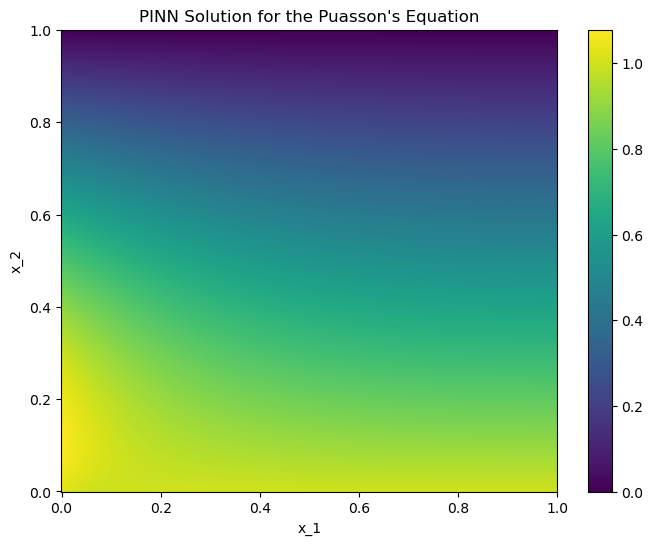

In [48]:
plt.figure(figsize=(8, 6))
plt.pcolor(x1_mesh, x2_mesh, u_pinn, cmap='viridis')
plt.colorbar()
plt.xlabel('x_1')
plt.ylabel('x_2')
plt.title('PINN Solution for the Puasson\'s Equation')
plt.savefig("2d_poisson_robin_equation_exact_solution_heatmap.png")
plt.show(block=False)

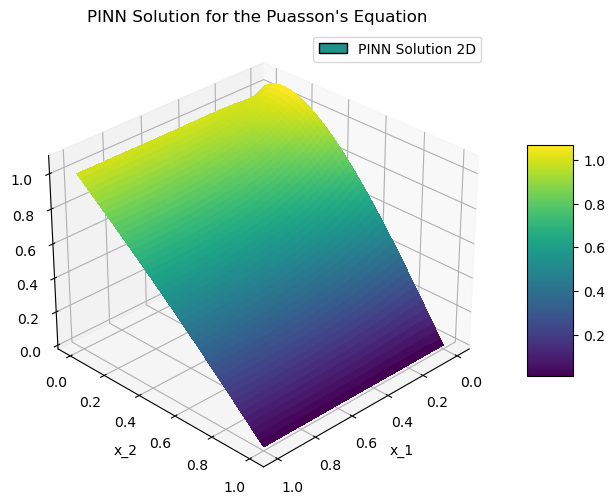

In [49]:
fig = plt.figure(figsize=(10, 6))
ax = fig.add_subplot(111, projection='3d')

# line, = ax.plot(np.ones_like(x_test_1D) * 0.5, x_test_1D, u_pred_1D, label='PINN Solution 1D', zorder=2)
# line2, = ax.plot(np.ones_like(x_test_1D) * 0.5, x_test_1D, U_exact_1D, label='Exact Solution 1D', zorder=1)
surf = ax.plot_surface(x1_mesh, x2_mesh, u_pinn, cmap='viridis', linewidth=0, antialiased=False, label='PINN Solution 2D', zorder=0)
#ax.plot(np.ones_like(x_test_1D) * 0.5, x_test_1D, U_exact_1D, label='Exact Solution 1D')
ax.set_xlabel('x_1')
ax.set_ylabel('x_2')
ax.set_zlabel('u')
ax.set_title('PINN Solution for the Puasson\'s Equation')
color_for_legend = cm.viridis(0.5)  # Get the color from the colormap
proxy = Rectangle((0, 0), 1, 1, fc=color_for_legend, edgecolor="k")
ax.legend([proxy], ['PINN Solution 2D'])
#ax.legend([line, line2, proxy], ['PINN Solution 1D', 'Exact Solution 1D', 'PINN Solution 2D'])
fig.colorbar(surf, shrink=0.5, aspect=5)
ax.view_init(elev=30, azim=45)
plt.savefig("2d_poisson_robin_equation_approx_solution.png")
plt.show()

Solving useing FEM
Solving linear variational problem.


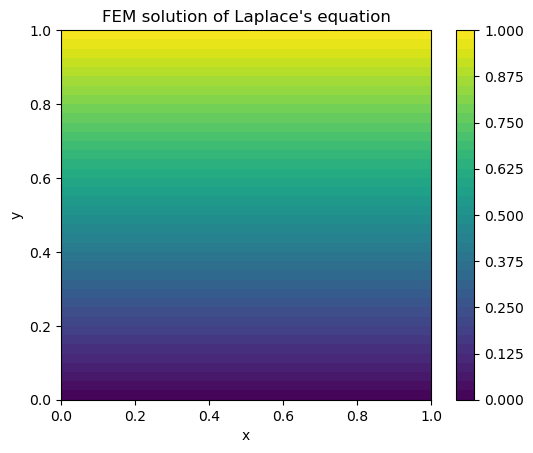

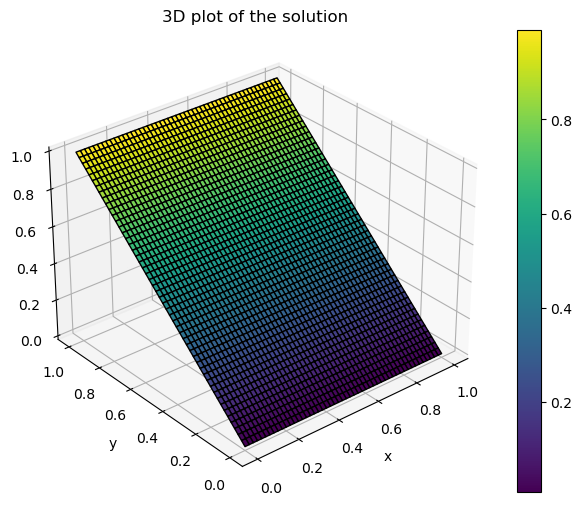

Mean Squared Error (PINN and FEM): 0.34798941618764223
Relative error (PINN and FEM): 100.00%


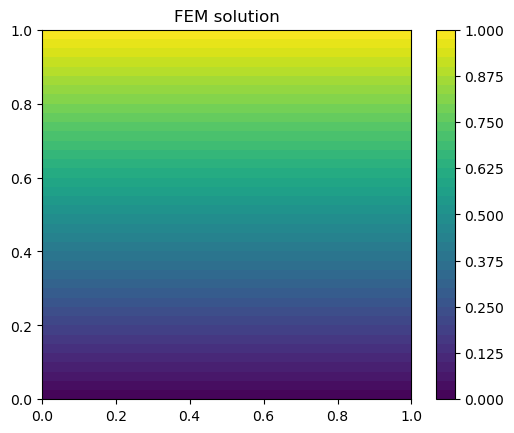

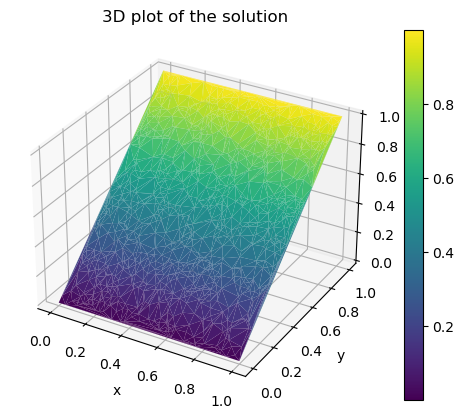

In [50]:
print("Solving useing FEM")

import numpy as np
from scipy.spatial import Delaunay

n_interior_points = 1000  # Number of interior points to generate
interior_points = np.random.rand(n_interior_points, 2)

corners = np.array([
    [L_x1, L_x2],  # Bottom left corner
    [R_x1, L_x2],  # Bottom right corner
    [R_x1, R_x2],  # Top right corner
    [L_x1, R_x2]   # Top left corner
])

interior_points[:, 0] = interior_points[:, 0] * (R_x1 - L_x1) + L_x1
interior_points[:, 1] = interior_points[:, 1] * (R_x2 - L_x2) + L_x2
points = np.vstack([corners, interior_points])
tri = Delaunay(points)

from fenics import *
import matplotlib.pyplot as plt
import numpy as np

mesh = Mesh()
editor = MeshEditor()
editor.open(mesh, "triangle", 2, 2)
editor.init_vertices(len(points))
for i, vertex in enumerate(points):
    editor.add_vertex(i, vertex)
editor.init_cells(len(tri.simplices))
for i, simplex in enumerate(tri.simplices):
    editor.add_cell(i, simplex)
editor.close()

V = FunctionSpace(mesh, 'P', 1)
n = FacetNormal(mesh)


# Create mesh and define function space
nx, ny = 100, 100

# Define boundary conditions
def boundary_upper(x, on_boundary):
    return on_boundary and near(x[1], R_x2)

def boundary_lower(x, on_boundary):
    return on_boundary and near(x[1], L_x2)

class LeftBoundary(SubDomain):
    def inside(self, x, on_boundary):
        return on_boundary and near(x[0], L_x1)

Dirichlet_up_2D = 1.0
Dirichlet_down_2D = 0.0
bc_upper = DirichletBC(V, Constant(Dirichlet_up_2D), boundary_upper)
bc_lower = DirichletBC(V, Constant(Dirichlet_down_2D), boundary_lower)

# Initialize mesh function for boundary domains
boundaries = MeshFunction('size_t', mesh, mesh.topology().dim() - 1, 0)
left_boundary = LeftBoundary()
left_boundary.mark(boundaries, 1)

# Define measure for integrating over boundaries
ds = Measure('ds', domain=mesh, subdomain_data=boundaries)

bcs = [bc_upper, bc_lower]

# Define problem
u = TrialFunction(V)
v = TestFunction(V)
f = Constant(0)#Expression('-pi * sin(pi * x[0]) * sin(pi * x[1])', degree=2)
g = Constant(0)
a = -dot(grad(u), grad(v))*dx - Constant(-10)*u*v*ds(1) + dot(grad(u), n)*v*ds(1)
L = f*v*dx + g*v*ds(1)

# Compute solution
u_fenics_app = Function(V)
solve(a == L, u_fenics_app, bcs)

# Plot solution using matplotlib
c = plot(u_fenics_app)
plt.colorbar(c)
plt.title("FEM solution of Laplace's equation")
plt.xlabel('x')
plt.ylabel('y')
plt.savefig('fenics_solution_half_dirichlet_Laplace_heatmap.png')
plt.show()

# Create a 3D plot
fig = plt.figure(figsize=(8, 6))
ax = fig.add_subplot(111, projection='3d')

x = np.linspace(L_x1, R_x1, N_of_test_points_2D)
y = np.linspace(L_x2, R_x2, N_of_test_points_2D)
X, Y = np.meshgrid(x, y)
points = np.vstack((X.ravel(), Y.ravel())).T

# Initialize an array to store the solution
u_fenics = np.zeros_like(points[:, 0])

# Evaluate the FEniCS solution at each point
for i, point in enumerate(points):
    u_fenics[i] = u_fenics_app(point)

# Reshape the solution to a 2D grid for plotting or comparison
u_fem = u_fenics.reshape((len(x), len(y)))

surf = ax.plot_surface(X, Y, u_fem, cmap='viridis', edgecolor='k')
plt.colorbar(surf)
plt.title("3D plot of the solution")
plt.xlabel('x')
plt.ylabel('y')
ax.set_zlabel('u')
ax.view_init(elev=30, azim=-130)
plt.savefig('fenics_solution_half_dirichlet_Laplace_3D.png')
plt.show()

print("Mean Squared Error (PINN and FEM):", np.mean((u_fem - u_pinn)**2))

relative_error = calculate_max_relative_error(u_fem, u_pinn)
print(f"Relative error (PINN and FEM): {relative_error:.2f}%")



c = plot(u_fenics_app)
plt.colorbar(c)
plt.title("FEM solution")
plt.show()

# Evaluate solution at mesh vertices for 3D plotting
x = mesh.coordinates()[:, 0]
y = mesh.coordinates()[:, 1]
u_fenics = np.array([u_fenics_app(point) for point in mesh.coordinates()])

# 3D plot
fig = plt.figure()
ax = fig.add_subplot(111, projection='3d')
surf = ax.plot_trisurf(x, y, u_fenics, cmap='viridis', edgecolor='none')
plt.colorbar(surf)
plt.title("3D plot of the solution")
ax.set_xlabel('x')
ax.set_ylabel('y')
ax.set_zlabel('u')
plt.show()



Solving linear variational problem.
(1000, 1000)


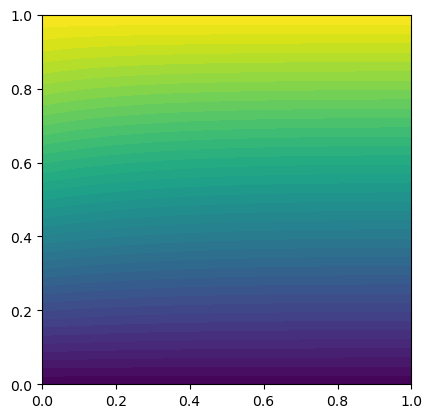

In [51]:
from fenics import *

# Create mesh and define function space
N = N_of_test_points_2D-1
mesh = UnitSquareMesh(N, N)
V = FunctionSpace(mesh, 'P', 1)

# Define boundary condition
u_top = Constant(1.0)
u_bottom = Constant(0.0)

def boundary_top(x, on_boundary):
    return on_boundary and near(x[1], 1)

def boundary_bottom(x, on_boundary):
    return on_boundary and near(x[1], 0)

bc_top = DirichletBC(V, u_top, boundary_top)
bc_bottom = DirichletBC(V, u_bottom, boundary_bottom)

# Collect Dirichlet boundary conditions
bcs = [bc_top, bc_bottom]

# Define variational problem
u_fenics = TrialFunction(V)
v = TestFunction(V)
f = Constant(0)
a = dot(grad(u_fenics), grad(v))*dx
L = f*v*dx

# Neumann boundary condition is naturally handled if we do not specify anything on those boundaries

# Robin boundary condition
class LeftBoundary(SubDomain):
    def inside(self, x, on_boundary):
        return on_boundary and near(x[0], 0)

left_boundary = LeftBoundary()
boundary_markers = MeshFunction('size_t', mesh, mesh.topology().dim()-1, 0)
left_boundary.mark(boundary_markers, 1)

ds = Measure('ds', domain=mesh, subdomain_data=boundary_markers)
a += Constant(-alpha)*u_fenics*v*ds(1) + dot(grad(u_fenics), grad(v))*ds(1)  # Robin condition: -u + du/dn = 0 on left boundary
L += Constant(0)*v*ds(1)  # Assuming g = 0 for simplicity

# Compute solution
u_fenics = Function(V)
solve(a == L, u_fenics, bcs)
u_fem = np.flip(u_fenics.compute_vertex_values(mesh).reshape((N_of_test_points_2D, N_of_test_points_2D)))
print(u_fem.shape)
# Save solution to file in VTK format
vtkfile = File('poisson_solution.pvd')
vtkfile << u_fenics

plot(u_fenics)
plt.show()


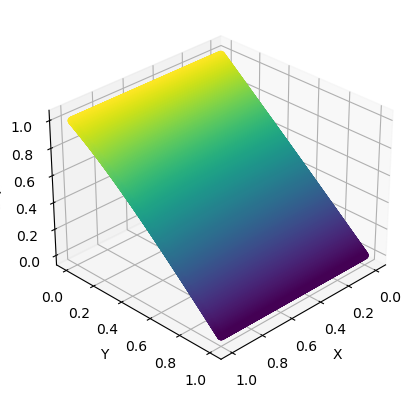

In [53]:
coordinates = mesh.coordinates()

# The mesh coordinates are in 2D, so we split them for plotting
x1 = coordinates[:, 0]
x2 = coordinates[:, 1]

# Create a 3D plot
fig = plt.figure()
ax = fig.add_subplot(111, projection='3d')

# The scatter plot takes x, y, and z coordinates for each point
ax.scatter(x1, x2, u_fem, c=u_fem, cmap='viridis')  # Color by the solution value

# Set labels for axes
ax.set_xlabel('X')
ax.set_ylabel('Y')
ax.set_zlabel('Solution u')
ax.view_init(elev=30, azim=45)

plt.show()

In [54]:
print("Mean Squared Error (PINN and FEM):", np.mean((u_fem - u_pinn)**2))

relative_error = calculate_max_relative_error(u_fem, u_pinn)
print(f"Relative error (PINN and FEM): {relative_error:.2f}%")


Mean Squared Error (PINN and FEM): 0.006746337137556534
Relative error (PINN and FEM): 8.23%
